Load Data

In [1]:
import json
import cv2
import numpy as np
import os
from skimage.feature import hog
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

anotations_path = 'archive'
train_anotations_file = 'train_annotations'
test_anotations_file = 'valid_annotations'

In [2]:
def get_records(path, file): 
    with open(os.path.join(path, file), 'r') as f:
        data = f.read()

    records = json.loads(data)
    return records

def get_image(path):
    files = os.listdir(path)
    image = []
    
    for file in files:
        img = cv2.imread(os.path.join(path, file))
        image.append(img)
    return image

def extract_hog_features(images):
    hog_features = []
    for image in images:
        #resized
        #把rgb转换为灰度图
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #用otsu转成2值图
        ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        image = cv2.resize(image, (256, 256))
        hog_feature = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        hog_features.append(hog_feature)
    return np.array(hog_features)

#构建BoW特征向量
def build_visual_vocabulary(hog_features, num_clusters=50):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(hog_features)
    return kmeans.cluster_centers_

#构建BoW特征向量
def build_bow_features(hog_features, visual_vocabulary):
    bow_features = []
    for hog_feature in hog_features:
        distances = []
        for cluster in visual_vocabulary:
            distance = np.linalg.norm(hog_feature-cluster)
            distances.append(distance)
        bow_feature = np.zeros(len(visual_vocabulary))
        bow_feature[np.argmin(distances)] = 1
        bow_features.append(bow_feature)
    return np.array(bow_features)


In [3]:
train_data = get_records(anotations_path, train_anotations_file)
test_data = get_records(anotations_path, test_anotations_file)

In [4]:
detection_train_images = get_image('archive/train/train')
detection_test_images = get_image('archive/valid/valid')
detection_train_labels = []
for i in range(len(train_data)):
    #add bbox and category_id
    category_id = train_data[i]['category_id']
    xcenter = ((2*train_data[i]['bbox'][0]+train_data[i]['bbox'][2])/2)/detection_train_images[i].shape[0]
    ycenter = ((2*train_data[i]['bbox'][1]+train_data[i]['bbox'][3])/2)/detection_train_images[i].shape[1]
    width = train_data[i]['bbox'][2]/detection_train_images[i].shape[0]
    height = train_data[i]['bbox'][3]/detection_train_images[i].shape[1]
    detection_train_labels.append([xcenter, ycenter, width, height, category_id])


detection_test_labels = []
for i in range(len(test_data)):
    category_id = test_data[i]['category_id']
    xcenter = ((2*test_data[i]['bbox'][0]+test_data[i]['bbox'][2])/2)/detection_test_images[i].shape[0]
    ycenter = ((2*test_data[i]['bbox'][1]+test_data[i]['bbox'][3])/2)/detection_test_images[i].shape[1]
    width = test_data[i]['bbox'][2]/detection_test_images[i].shape[0]
    height = test_data[i]['bbox'][3]/detection_test_images[i].shape[1]
    detection_test_labels.append([xcenter, ycenter, width, height, category_id])

print(detection_train_labels[0])
print(detection_test_labels[0])

[0.34609375, 0.5125, 0.3203125, 0.946875, 1]
[0.5875, 0.55546875, 0.465625, 0.8203125, 1]


In [5]:
X_train_hog_features = extract_hog_features(detection_train_images)
X_test_hog_features = extract_hog_features(detection_test_images)
visual_vocabulary = build_visual_vocabulary(X_train_hog_features)
visual_vocabulary1 = build_visual_vocabulary(X_test_hog_features)
X_train_bow_features = build_bow_features(X_train_hog_features, visual_vocabulary)
X_test_bow_features = build_bow_features(X_test_hog_features, visual_vocabulary1)

c:\Users\wudus\miniconda3\envs\Curry\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\wudus\miniconda3\envs\Curry\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\wudus\miniconda3\envs\Curry\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\wudus\miniconda3\envs\Curry\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available th

In [8]:
import os
folder_path = 'dataset/dataset//valid/labels'
files = os.listdir('archive/valid/valid')

print(files)
i = 0
#遍历文件夹
for file in files:
    new_file = file.split('.')[0] + '.txt'
    with open(os.path.join(folder_path, new_file), 'w') as f:
        f.write(str(detection_test_labels[i][4]-1) + ' ' + str(detection_test_labels[i][0]) + ' ' + str(detection_test_labels[i][1]) + ' ' + str(detection_test_labels[i][2]) + ' ' + str(detection_test_labels[i][3]))
        print(i)
    i += 1

['image_id_000.jpg', 'image_id_001.jpg', 'image_id_002.jpg', 'image_id_003.jpg', 'image_id_004.jpg', 'image_id_005.jpg', 'image_id_006.jpg', 'image_id_007.jpg', 'image_id_008.jpg', 'image_id_009.jpg', 'image_id_010.jpg', 'image_id_011.jpg', 'image_id_012.jpg', 'image_id_013.jpg', 'image_id_014.jpg', 'image_id_015.jpg', 'image_id_016.jpg', 'image_id_017.jpg', 'image_id_018.jpg', 'image_id_019.jpg', 'image_id_020.jpg', 'image_id_021.jpg', 'image_id_022.jpg', 'image_id_023.jpg', 'image_id_024.jpg', 'image_id_025.jpg', 'image_id_026.jpg', 'image_id_027.jpg', 'image_id_028.jpg', 'image_id_029.jpg', 'image_id_030.jpg', 'image_id_031.jpg', 'image_id_032.jpg', 'image_id_033.jpg', 'image_id_034.jpg', 'image_id_035.jpg', 'image_id_036.jpg', 'image_id_037.jpg', 'image_id_038.jpg', 'image_id_039.jpg', 'image_id_040.jpg', 'image_id_041.jpg', 'image_id_042.jpg', 'image_id_043.jpg', 'image_id_044.jpg', 'image_id_045.jpg', 'image_id_046.jpg', 'image_id_047.jpg', 'image_id_048.jpg', 'image_id_049.jpg',

In [9]:
import os
folder_path = 'dataset/dataset/train/labels'
files = os.listdir('archive/train/train')

print(files)
i = 0
#遍历文件夹
for file in files:
    new_file = file.split('.')[0] + '.txt'
    with open(os.path.join(folder_path, new_file), 'w') as f:
        f.write(str(detection_train_labels[i][4]-1) + ' ' + str(detection_train_labels[i][0]) + ' ' + str(detection_train_labels[i][1]) + ' ' + str(detection_train_labels[i][2]) + ' ' + str(detection_train_labels[i][3]))
        print(i)
    i += 1


['image_id_000.jpg', 'image_id_001.jpg', 'image_id_002.jpg', 'image_id_003.jpg', 'image_id_004.jpg', 'image_id_005.jpg', 'image_id_006.jpg', 'image_id_007.jpg', 'image_id_008.jpg', 'image_id_009.jpg', 'image_id_010.jpg', 'image_id_011.jpg', 'image_id_012.jpg', 'image_id_013.jpg', 'image_id_014.jpg', 'image_id_015.jpg', 'image_id_016.jpg', 'image_id_017.jpg', 'image_id_018.jpg', 'image_id_019.jpg', 'image_id_020.jpg', 'image_id_021.jpg', 'image_id_022.jpg', 'image_id_023.jpg', 'image_id_024.jpg', 'image_id_025.jpg', 'image_id_026.jpg', 'image_id_027.jpg', 'image_id_028.jpg', 'image_id_029.jpg', 'image_id_030.jpg', 'image_id_031.jpg', 'image_id_032.jpg', 'image_id_033.jpg', 'image_id_034.jpg', 'image_id_035.jpg', 'image_id_036.jpg', 'image_id_037.jpg', 'image_id_038.jpg', 'image_id_039.jpg', 'image_id_040.jpg', 'image_id_041.jpg', 'image_id_042.jpg', 'image_id_043.jpg', 'image_id_044.jpg', 'image_id_045.jpg', 'image_id_046.jpg', 'image_id_047.jpg', 'image_id_048.jpg', 'image_id_049.jpg',

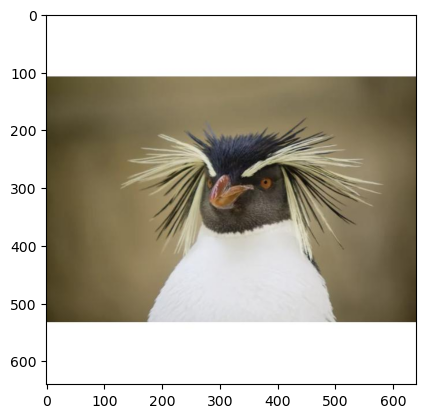

In [ ]:
image = cv2.imread('archive/valid/valid/image_id_003.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
